### create array

In [120]:
import numpy as np
import pandas as pd

# Choose frequency, binsize, longitude, latitude
freq = 'D'
binsize = 2
longitude_W = 134  # minimum is 134
longitude_E = 174  # maximum is 174
latitude_S = 10  # minimum is 10
latitude_N = 60  # minimum is 60

# load earthquake data for defined area
data = pd.read_csv('data/Japan_10_60_134_174_1973_2023_V2.csv', index_col=0)
data['Time'] = pd.to_datetime(data.Time)
data = data[(data.Longitude >= longitude_W) & (data.Longitude <= longitude_E) & (data.Latitude >= latitude_S) & (data.Latitude <= latitude_N)]
data.set_index('Time', inplace=True)
df = data.sort_index()

# Bin the longitude and latitude values into 2x2 degree bins
df['Longitude_bin'] = pd.cut(df['Longitude'], bins=np.arange(longitude_W, longitude_E + 1, binsize))  # Change bin size to 2 degrees
df['Latitude_bin'] = pd.cut(df['Latitude'], bins=np.arange(latitude_S, latitude_N + 1, binsize))  # Change bin size to 2 degrees

# Group the data by longitude bin, latitude bin, depth bin, and day, and compute the maximum magnitude within each group
grouped = df.groupby(['Longitude_bin', 'Latitude_bin', pd.Grouper(freq=freq, level="Time")]).agg({'Magnitude': 'max', 'Depth': 'mean'})
grouped = grouped.unstack().fillna(0)

# Reshape the resulting data into a tensor with shape (time, longitude, latitude, 4)
time = len(grouped.columns.levels[1])
longitude = len(grouped.index.levels[0])
latitude = len(grouped.index.levels[1])
tensor = np.zeros((time, longitude, latitude, 4))

for t in range(time):
    tensor[t, :, :, 0] = grouped['Magnitude'].iloc[:, t].values.reshape(longitude, latitude)
    tensor[t, :, :, 3] = grouped['Depth'].iloc[:, t].values.reshape(longitude, latitude)

latitude_values = np.linspace(latitude_S, latitude_N - binsize, latitude) + binsize / 2
longitude_values = np.linspace(longitude_W, longitude_E - binsize, longitude) + binsize / 2

tensor[:, :, :, 1] = np.repeat(latitude_values, longitude).reshape(latitude, longitude).T
tensor[:, :, :, 2] = np.tile(longitude_values, latitude).reshape(latitude, longitude).T

# Rotate dimensions corresponding to 20 and 25, 90 degrees anti-clockwise
tensor = np.transpose(tensor, axes=(0, 2, 1, 3))
tensor = np.flip(tensor, axis=1)

# Print the shape of the tensor
print(tensor.shape)

# Reshape tensor into matrix
matrix = np.reshape(tensor[:,:,:,0], (tensor.shape[0], -1))
# Keep only the columns with at least one number bigger than 0
matrix = matrix[:, (matrix > 0).sum(axis=0) >= 0]
print(matrix.shape)


(18260, 25, 20, 4)
(18260, 500)


### autocorrelation plot

In [ ]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import seaborn as sns

most_active = matrix.sum(axis=0).argmax()

sns.set(rc={'figure.figsize':(10,3)})
autocorrelation_plot(matrix[:,most_active])
plt.ylim(-.2, .2)
print(most_active)
plt.show()

### split the data

In [121]:
from sklearn.model_selection import train_test_split

# split data in train, val, test

# Activate when only forecasting one region
# matrix = np.reshape(matrix, (matrix.shape[0], matrix.shape[1], 1))

train, val_test = train_test_split(matrix, test_size=.3, shuffle=False, random_state=43)
val, test = train_test_split(val_test, test_size=.5, shuffle=False, random_state=43)

### create sliding window datasets

In [142]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf

def dataset_generator(data, seq_length, samp_rate, stride, cutoff):

  input_data = data
  target_data = data
  dataset = timeseries_dataset_from_array(input_data, targets=None, sequence_length=seq_length, sampling_rate=samp_rate, sequence_stride=stride, shuffle=False, batch_size=len(data))

  return dataset

# Set lookback timewindow
lookback_window = 30 * 72
cutoff = 4.5
future_timesteps = 30
timewindow = lookback_window + future_timesteps
samp_rate = 1
stride = future_timesteps

train_dataset = dataset_generator(train, timewindow, samp_rate, stride, cutoff)
val_dataset = dataset_generator(val, timewindow, samp_rate, stride, cutoff)
test_dataset = dataset_generator(test, timewindow, samp_rate, stride, cutoff)

# Create train set
for batch in train_dataset:
    X_train = batch[:,:-future_timesteps,:]
    X_train = np.reshape(X_train, (X_train.shape[0], -1))

    y_train = batch[:,-future_timesteps:,:]# >= cutoff
    y_train = np.max(y_train, axis=1)#.astype(int)
    # y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1])).astype(int)

# y_train = tf.reshape(y_train, shape=[y_train.shape[0], 1, y_train.shape[1]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
# y_train = tf.cast(tf.reduce_max(y_train, axis=2, keepdims=True) > 0, dtype=tf.int32)

# Create validation set
for batch in val_dataset:
    X_val = batch[:,:-future_timesteps,:]
    X_val = np.reshape(X_val, (X_val.shape[0], -1))

    y_val = batch[:,-future_timesteps:,:]# >= cutoff
    y_val = np.max(y_val, axis=1)#.astype(int)
    # y_val = np.reshape(y_val, (y_val.shape[0], 1, y_val.shape[1])).astype(int)

# y_val = tf.reshape(y_val, shape=[y_val.shape[0], 1, y_val.shape[1]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
# y_val = tf.cast(tf.reduce_max(y_val, axis=2, keepdims=True) > 0, dtype=tf.int32)

# Create test set
for batch in test_dataset:
    X_test = batch[:,:-future_timesteps,:]
    X_test = np.reshape(X_test, (X_test.shape[0], -1))

    y_test = batch[:,-future_timesteps:,:]# >= cutoff
    y_test = np.max(y_test, axis=1)#.astype(int)
    # y_test = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1])).astype(int)

# y_test = tf.reshape(y_test, shape=[y_test.shape[0], 1, y_test.shape[1]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
# y_test = tf.cast(tf.reduce_max(y_test, axis=2, keepdims=True) > 0, dtype=tf.int32)

################################# Use for MLP
# Flatten 1 and 2 dimensions of X's for multivariate MLP
# X_train = np.reshape(X_train, (X_train.shape[0],-1))
# X_val = np.reshape(X_val, (X_val.shape[0],-1))
# X_test = np.reshape(X_test, (X_test.shape[0],-1))

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(354, 1080000) (354, 500)
(19, 1080000) (19, 500)
(19, 1080000) (19, 500)


### multiple univariate linear regression

In [139]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Create a list to store the individual models
models = []
X_train = np.reshape(X_train, (X_train.shape[0], lookback_window, -1))
X_val = np.reshape(X_val, (X_val.shape[0], lookback_window, -1))
X_test = np.reshape(X_test, (X_test.shape[0], lookback_window, -1))

# Train a separate Linear Regression model for each target
for i in range(y_train.shape[1]):
    print(i)
    model = LinearRegression()
    model.fit(X_train[:,:,i], y_train[:, i])
    models.append(model)

# Predict the target variables using the individual models
# y_pred contains the predictions using the multiple univariate models
y_pred = np.zeros((y_val.shape[0], y_test.shape[1]))
for i, model in enumerate(models):
    y_pred[:, i] = model.predict(X_test[:,:,i])

true = y_test >= cutoff
pred = y_pred >= cutoff

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### multivariate linear regression

In [134]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
 
# Train a multi-output linear regression model on the data
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [135]:
# Predict the target variables
y_pred = model.predict(X_test)
true = y_test >= cutoff
pred = y_pred >= cutoff

In [ ]:
from joblib import dump, load
dump(model, 'models/Mu_LR_2x2_72M_2W_M4.5.joblib')
model = load('models/Mu_LR_2x2_72M_2W_M4.5.joblib')

### persistant model

In [143]:
y_val_shifted = np.roll(y_test, -1, axis=0)
true = y_val_shifted >= cutoff
pred = y_test >= cutoff

### evaluation metrics

In [144]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(np.array(true).flatten(), pred.flatten() )
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(np.array(true).flatten(), pred.flatten() )
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(np.array(true).flatten(), pred.flatten() )
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(np.array(true).flatten(), pred.flatten() )
print('F1 score: %f' % f1)

class_names = ['M<4.5', 'M>=4.5']

print(classification_report(np.array(true).flatten(), pred.flatten(), target_names=class_names))

# Calculate the proportion of the majority per row, column combination over all batches
majority_prop = np.mean(val >= cutoff, axis=0)[:]

# Calculate the complement for values lower than 0.5
majority_prop = np.where(majority_prop < 0.5, 1 - majority_prop, majority_prop)
zeroR = majority_prop.mean()

print("zeroR:", round(zeroR,4))

Accuracy: 0.932211
Precision: 0.472995
Recall: 0.472995
F1 score: 0.472995
              precision    recall  f1-score   support

       M<4.5       0.96      0.96      0.96      8889
      M>=4.5       0.47      0.47      0.47       611

    accuracy                           0.93      9500
   macro avg       0.72      0.72      0.72      9500
weighted avg       0.93      0.93      0.93      9500

zeroR: 0.9958


### confustion matrix

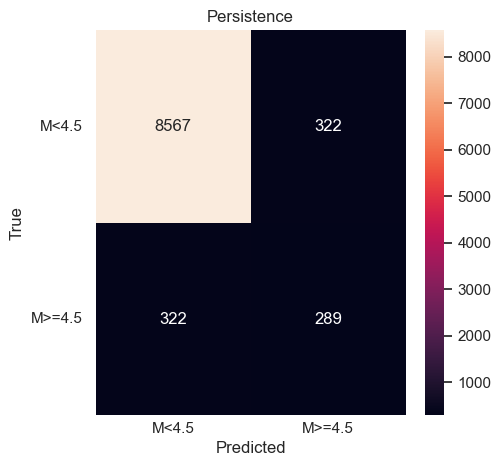

In [145]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set(rc={'figure.figsize':(5,5)})
p = sns.heatmap(confusion_matrix(np.array(true).flatten(), pred.flatten()), annot=True, fmt='g')
p.set_xlabel("Predicted")
p.set_ylabel("True")
p.set_title("Persistence")
p.xaxis.set_ticklabels(['M<4.5', 'M>=4.5'], ha="center", va="center")
p.yaxis.set_ticklabels(['M<4.5', 'M>=4.5'], rotation=0, va="center")
plt.savefig("graphs/CM_persistence_2x2_M45")

### ROC curve

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# y_pred = scaler.inverse_transform(y_prob)
# y_test = scaler.inverse_transform(y)

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(np.array(true).flatten(), pred.flatten())
roc_auc = auc(fpr, tpr)

# Plot micro-average ROC curve
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
        ''.format(roc_auc), color='blue', linewidth=1)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
# plt.savefig(savefig)
plt.show()

### PR curve

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, f1_score
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(np.array(true).flatten(), pred.flatten())
auc = auc(recall, precision)

# Calculate the proportion of the majority per row, column combination over all batches
majority_prop = np.mean(test >= cutoff, axis=0)[:]

# Calculate the complement for values lower than 0.5
majority_prop = np.where(majority_prop < 0.5, 1 - majority_prop, majority_prop)
zeroR = majority_prop.mean()

# plot the precision-recall curves
no_skill = (np.array(y_val).flatten() >= cutoff).sum() / len(np.array(y_val).flatten())
plt.plot([0, 1], [no_skill,no_skill], linestyle='--', label='positive class = %.3f' % (no_skill))
plt.plot(recall, precision, label='PR_curve, AUC = %.3f' % (auc))
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
# show the legend
plt.legend()
# show the plot
plt.show()

### plot predicted against true

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape data to grid
y_pred = np.reshape(y_pred, (y_pred.shape[0], tensor.shape[1], tensor.shape[2]))
true = np.reshape(y_val, (y_val.shape[0], tensor.shape[1], tensor.shape[2]))

# Choose timesteps to plot
timestep = 3


# Extract the data for the chosen timesteps from the tensor
data1 = y_pred[timestep, :, :] >= .5
data2 = true[timestep, :, :]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))

# Plot the data in each subplot
sns.heatmap(data1, cmap='coolwarm', vmin=0, vmax=1, linewidths=0.5, linecolor='grey', annot=False, ax=ax1)
sns.heatmap(data2, cmap='coolwarm', vmin=0, vmax=1, linewidths=0.5, linecolor='grey', annot=False, ax=ax2)

# Set the plot titles and axis labels
ax1.set_title(f'Predicted M{cutoff} at timestep {timestep}')
ax2.set_title(f'True M{cutoff} at timestep {timestep}')
ax1.set_xlabel('Longitude')
ax2.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Set the tick labels for the x and y axes of ax1
ax1.set_xticks(np.arange(0.5, data1.shape[1], 2))
ax1.set_xticklabels(grouped.index.levels[0][::2], rotation=90)
ax1.set_yticks(np.arange(0.5, data1.shape[0], 2))
ax1.set_yticklabels(grouped.index.levels[1][::-2].sort_values(ascending=False), rotation=0)

# Set the tick labels for the x axis of ax2
ax2.set_xticks(np.arange(0.5, data2.shape[1], 2))
ax2.set_xticklabels(grouped.index.levels[0][::2], rotation=90)
ax2.set_yticklabels([])



# Show the plot
# plt.savefig("graphs/Un_LR_2x2_1W_t3", bbox_inches="tight")
plt.show()